![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

# NOAA Heat Index - Heat stress analyses using Climate DT modeled data 2020-2040

Authors: Dr. Alen Berta (CGI), Cesare Rossi (CGI)

Licence: MIT

Reference:
https://confluence.ecmwf.int/display/CKB/Climate+extreme+indices+and+heat+stress+indicators+derived+from+CMIP6+global+climate+projections%3A+Product+User+Guide

Notes:
This example is intended for hands-on learning and does not constitute a comprehensive climatic study. This notebook will showcase the time series point analyses for 2 cities in Croatia (Zagreb as representative of continental climate and Dubrovnik as representative of Mediterranean climate). Service for analysing larger areas and exporting corresponding results in raster files will soon be available on Insula platform.


HI is calculated as multiple linear regression with temperature and relative humidity as input variables (https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020EF001885). The results are clasified in 4 levels:

- Caution (from 27 to 32)
- Extreme Caution (up to value 41)
- Danger (up to value 54)
- Extreme Danger (above value 54)

The data used here are based on SSP3 NEMO model, representing next to worst scenario modeled in Shared Socio-Economic Pathways (SSPs) predicting the highest population development and lowest GDP amongst the considered scenarios in the near future, with global mean temperature rising between 3.85 and 4.55 C until 2100. (more info and photo credit https://www.carbonbrief.org/explainer-how-shared-socioeconomic-pathways-explore-future-climate-change/)
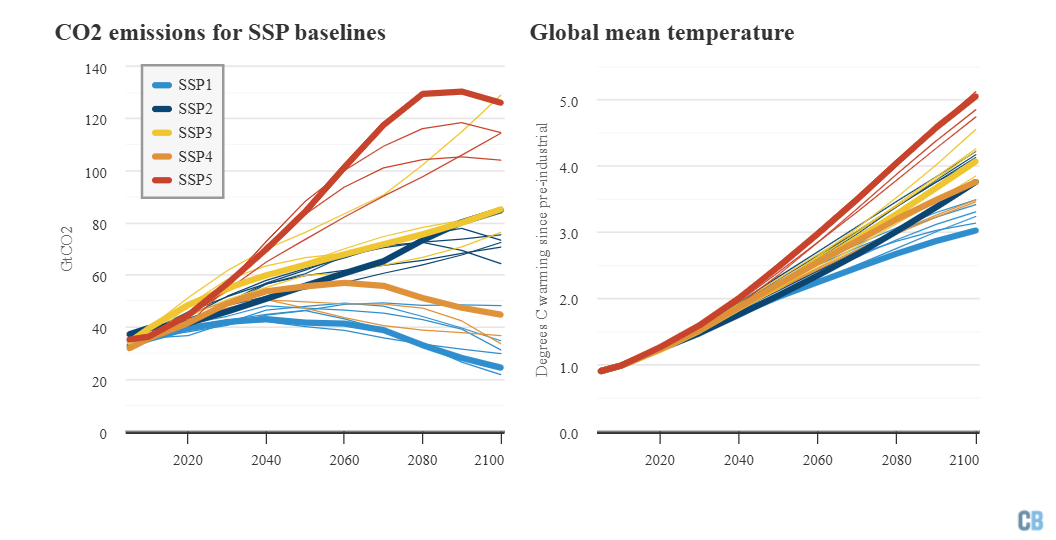

This notebook will provide the analyses relevant for detecting increased temperature stress due to climate change. The data used stem from Climate DT (https://destine.ecmwf.int/news/climate-change-adaptation-digital-twin-a-window-to-the-future-of-our-planet/) and will provide the calculation of some climate extreme indices (https://confluence.ecmwf.int/display/CKB/Climate+extreme+indices+and+heat+stress+indicators+derived+from+CMIP6+global+climate+projections%3A+Product+User+Guide).

Specifically we will present the approach to:
 1) Calculate and count the days of increased heat stress per month based on HUMIDEX index
 2) Visualize the same index/indicator on monthly level for selected year with the average and standard deviation values of 2020-2040 (extracted from the Climate DT)

The equations to calculate heat stress indicators are adapted from https://github.com/schwings-clemens/CDS_heat_stress_indicators.

## Data access

<div style="border: 2px solid #28a745; background-color: #d4edda; padding: 10px; border-radius: 5px;">
  <strong>💡 Tip:</strong> Provide here your Destination Earth credentials. Ensure that you requested and obtained an access policy upgrade, which is necessary to read the Climate DT data of this example. See <a href="https://platform.destine.eu/access-policy-upgrade/">https://platform.destine.eu/access-policy-upgrade</a>.
</div>

In [ ]:
%%capture cap
%run ./cacheb-authentication.py

In [2]:
output_1 = cap.stdout.split('}\n')
token = output_1[-1][0:-1]

from pathlib import Path
with open(Path.home() / ".netrc", "a") as fp:
    fp.write(token)

### Data loading

In [3]:
# load libraries and functions 
import xarray as xr
import pandas as pd
import os
from utils import noaa_hi

In [4]:
data = xr.open_dataset(
    "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr",
    storage_options={"client_kwargs":{"trust_env":"true"}},
    chunks={},
    engine="zarr",
)

In [5]:
data

<xarray.Dataset> Size: 800TB
Dimensions:           (time: 175320, latitude: 4096, longitude: 8193)
Coordinates:
    entireAtmosphere  float64 8B ...
  * latitude          (latitude) float64 33kB -90.0 -89.96 -89.91 ... 89.96 90.0
  * longitude         (longitude) float64 66kB -180.0 -180.0 ... 180.0 180.0
    step              timedelta64[ns] 8B ...
    surface           float64 8B ...
  * time              (time) datetime64[ns] 1MB 2020-01-01 ... 2039-12-31T23:...
Data variables: (12/34)
    blh               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    chnk              (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    d2m               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    e                 (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ewss              (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    hcc               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ...                ...
    tp                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    tprate            (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    tsr               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ttr               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    u10               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    v10               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-11-14T08:10 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

Load 2m temperature, dew temperature and presure values.

In [6]:
t2m = data.t2m.astype("float32") - 273.15
t2m.attrs["units"] = "C"

d2m = data.d2m.astype("float32") - 273.15
d2m.attrs["units"] = "C"

sp=data.sp.astype("float32")

Add the Lat/Lon for point time series and prepare the input data for calculation

In [7]:
# load respective Lat/Lon
zagreb_lat_lon=(45.8150,15.9819)
dubrovnik_lat_lon=(43.5147,16.4435)

Select your year of interest between 2020 and 2040.

In [8]:
year_of_interest = "2035"

Decide whether you would like to perform a full analysis between 2020 and 2040.

In [9]:
full_2020_2040_analysis = False # If True, the analysis is performed against the whole period, then comparing it to the year_of_interest

<div style="border: 2px solid #f5c518; background-color: #fff3cd; padding: 10px; border-radius: 5px;">
  <strong>⚠️ Warning:</strong> The computation time for one city/pixel/point for 2020-2040 might require 1.5 hours or more. Therefore, <b>for initial experiments, we suggest keeping the variable full_2020_2040_analysis set to False.</b>
</div>

In [10]:
# Select the data for Zagreb
t2m_zagreb = t2m.sel(latitude=zagreb_lat_lon[0], longitude=zagreb_lat_lon[1], method='nearest')
d2m_zagreb = d2m.sel(latitude=zagreb_lat_lon[0], longitude=zagreb_lat_lon[1], method='nearest')

# Select the data for dubrovnik
t2m_dubrovnik = t2m.sel(latitude=dubrovnik_lat_lon[0], longitude=dubrovnik_lat_lon[1], method='nearest')
d2m_dubrovnik = d2m.sel(latitude=dubrovnik_lat_lon[0], longitude=dubrovnik_lat_lon[1], method='nearest')

if not full_2020_2040_analysis:
    # Subset the data for a given year
    t2m_zagreb = t2m_zagreb.sel(time=year_of_interest)
    d2m_zagreb = d2m_zagreb.sel(time=year_of_interest)
    t2m_dubrovnik = t2m_dubrovnik.sel(time=year_of_interest)
    d2m_dubrovnik = d2m_dubrovnik.sel(time=year_of_interest)

# Convert the temperature from C to F
t2m_zagreb_f = 9/5 * t2m_zagreb + 32
t2m_dubrovnik_f = 9/5 * t2m_dubrovnik + 32

# Calculate relative humidity for Zagreb and dubrovnik
RH_zagreb = noaa_hi.calculate_relative_humidity(t2m_zagreb, d2m_zagreb)
RH_dubrovnik = noaa_hi.calculate_relative_humidity(t2m_dubrovnik, d2m_dubrovnik)

### NOAA Heat Index calculation

The following cells will:

1) Calculate NOAA Heat Index based on temperature and humidity on preselected datasets (in this case Zagreb and Dubrovnik between 2020 and 2040),
2) Detect the maximum value of index within the day
3) Categorize this value into NOAA HI categories
4) Count unique categories per month
5) extract the values for one selected year (2035),
6) calculate the mean and standard deviation for each month between 2020-2040,
7) plot on one plot per NOAA HI category the average from 2020-2040 as point, st.dev from 2020-2040 as lines and the values for selected year/month as bars 


In [11]:
# Calculate Heat Index for Zagreb and dubrovnik
HI_zagreb = noaa_hi.HI_NOAA(t2m_zagreb_f, RH_zagreb)
HI_dubrovnik = noaa_hi.HI_NOAA(t2m_dubrovnik_f, RH_dubrovnik)

<div style="border: 2px solid #f5c518; background-color: #fff3cd; padding: 10px; border-radius: 5px;">
  <strong>⚠️ Warning: </strong>The following cell usually takes <b>2 minutes</b> for each city/pixel/point. <b>If the variable full_2020_2040_analysis is set to True it might require 1.5 hour or more for one city/pixel/point.</b>
</div>

In [12]:
# Resample to max daily value
HI_zagreb.name = "Heat_Index"
%time HI_zagreb_daily_max = HI_zagreb.resample(time='D').max().to_dataframe().reset_index()
HI_dubrovnik.name = "Heat_Index"
%time HI_dubrovnik_daily_max = HI_dubrovnik.resample(time='D').max().to_dataframe().reset_index()

CPU times: user 1min 1s, sys: 18.8 s, total: 1min 20s
Wall time: 2min 50s
CPU times: user 41.8 s, sys: 18.3 s, total: 1min
Wall time: 2min 1s


In [13]:
# Apply categorization
HI_zagreb_daily_max['Category'] = HI_zagreb_daily_max['Heat_Index'].apply(noaa_hi.categorize_hi)
HI_dubrovnik_daily_max['Category'] = HI_dubrovnik_daily_max['Heat_Index'].apply(noaa_hi.categorize_hi)

# Count the number of days within each month per category
HI_zagreb_monthly_counts = HI_zagreb_daily_max.groupby([HI_zagreb_daily_max['time'].dt.to_period('M'), 'Category']).size().unstack(fill_value=0)
HI_dubrovnik_monthly_counts = HI_dubrovnik_daily_max.groupby([HI_dubrovnik_daily_max['time'].dt.to_period('M'), 'Category']).size().unstack(fill_value=0)

In [14]:
# Save the results - this is useful later in case you would like to skip to the computation step above and play with the data
csv_directory = "csv"
if not os.path.exists(csv_directory):
    os.makedirs(csv_directory)

HI_zagreb_monthly_counts.to_csv(f'{csv_directory}/HI_monthly_zagreb.csv')
HI_dubrovnik_monthly_counts.to_csv(f'{csv_directory}/HI_monthly_dubrovnik.csv')

In [15]:
# Read the data from CSV files
HI_zagreb_monthly_counts = pd.read_csv(f'{csv_directory}/HI_monthly_zagreb.csv', index_col=0, parse_dates=True)
HI_dubrovnik_monthly_counts = pd.read_csv(f'{csv_directory}/HI_monthly_dubrovnik.csv', index_col=0, parse_dates=True)

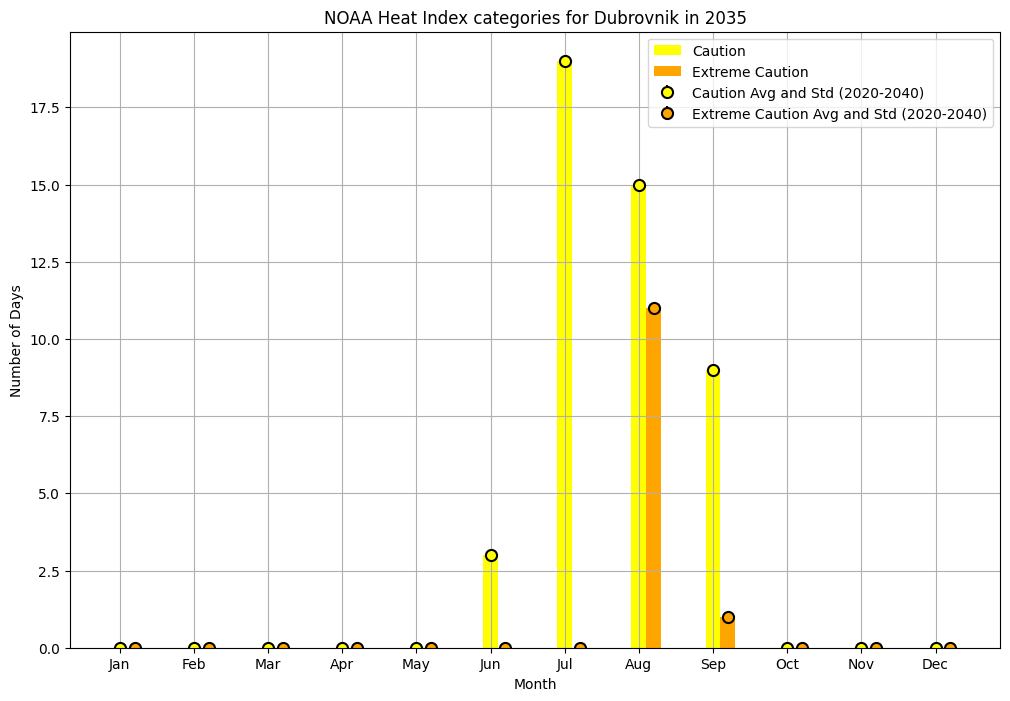

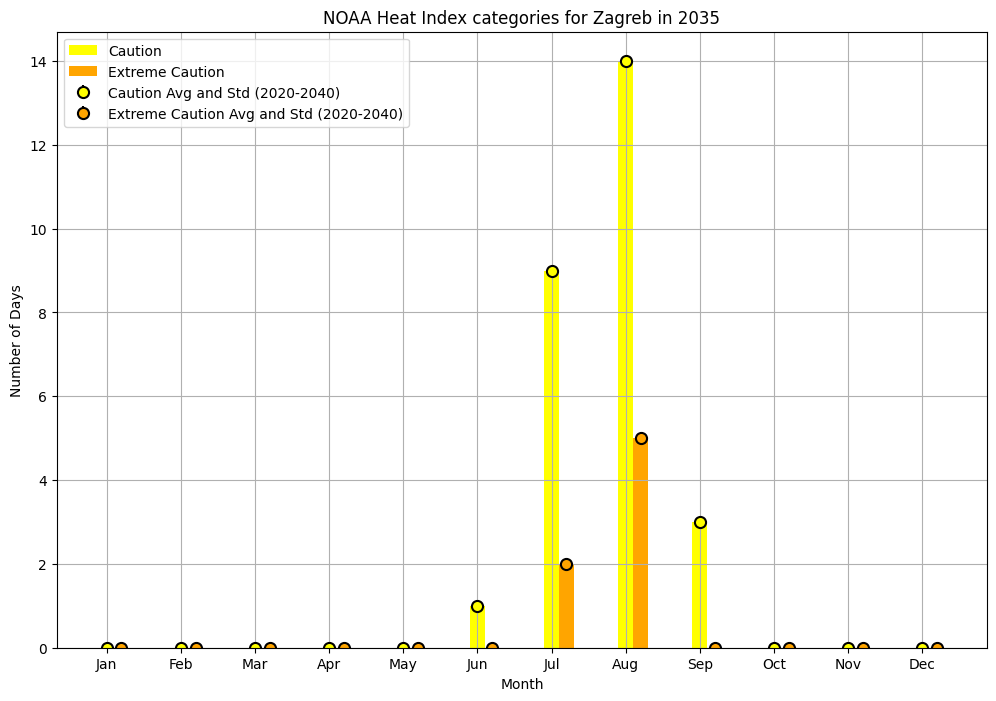

In [16]:
# Calculate the average and standard deviation per month for each category for the whole data range
HI_zagreb_monthly_stats = HI_zagreb_monthly_counts.groupby(HI_zagreb_monthly_counts.index.month).agg(['mean', 'std'])
HI_dubrovnik_monthly_stats = HI_dubrovnik_monthly_counts.groupby(HI_dubrovnik_monthly_counts.index.month).agg(['mean', 'std'])

# Select the data for the specified year
HI_dubrovnik_yoi = HI_dubrovnik_monthly_counts.loc[str(year_of_interest)]
HI_zagreb_yoi = HI_zagreb_monthly_counts.loc[str(year_of_interest)]

# Plot for Dubrovnik
noaa_hi.plot_heat_index_categories(HI_dubrovnik_yoi, HI_dubrovnik_monthly_stats, "Dubrovnik", year_of_interest)

# Plot for Zagreb
noaa_hi.plot_heat_index_categories(HI_zagreb_yoi, HI_zagreb_monthly_stats, "Zagreb", year_of_interest)

<div style="border: 2px solid #909090; background-color: #e1e1e1; padding: 10px; border-radius: 5px;">

As a reference, the following graphs present the results of the full computation (i.e., <i>full_2020_2040_analysis = True</i>), comparing the year 2035 with the entire 2020–2040 range.

<table>
<tr>
    <th><img src="images/noaa_hi_output_0.png" width="600"></th>
    <th><img src="images/noaa_hi_output_1.png" width="600"></th>
</table>
</div>